In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.metrics import explained_variance_score, mean_squared_error


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/doctor-fees-prediction/Final_Train.xlsx
/kaggle/input/doctor-fees-prediction/Final_Test.xlsx


<h1>Data gathering</h1>

In [2]:
train_data = pd.read_excel("/kaggle/input/doctor-fees-prediction/Final_Train.xlsx")
test_data = pd.read_excel("/kaggle/input/doctor-fees-prediction/Final_Test.xlsx")

In [3]:
train_data.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       5961 non-null   object
 1   Experience          5961 non-null   object
 2   Rating              2659 non-null   object
 3   Place               5936 non-null   object
 4   Profile             5961 non-null   object
 5   Miscellaneous_Info  3341 non-null   object
 6   Fees                5961 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 326.1+ KB


In [5]:
X = train_data.drop('Fees', axis = 1)
Y = train_data['Fees']

In [6]:
X['Qualification'].value_counts()[:10]

BDS                                               488
BHMS                                              477
BAMS                                              471
MBBS                                              334
MBBS, MS - ENT                                    220
MBBS, MD - Dermatology                            178
MBBS, MD - General Medicine                       177
MBBS, MD - Dermatology , Venereology & Leprosy    140
BHMS, MD - Homeopathy                              93
MBBS, DDVL                                         92
Name: Qualification, dtype: int64

In [7]:
X['Profile'].value_counts()

Dentist             1397
General Medicine    1173
Dermatologists      1034
Homeopath            843
Ayurveda             786
ENT Specialist       728
Name: Profile, dtype: int64

In [8]:
X['Place'].value_counts()

HSR Layout, Bangalore          75
Andheri West, Mumbai           70
Dwarka, Delhi                  67
Banjara Hills, Hyderabad       64
Mulund West, Mumbai            54
                               ..
Mankhurd, Mumbai                1
Ramamangalam, Ernakulam         1
Hyder Nagar, Hyderabad          1
Jahangirpuri, Delhi             1
Muttada, Thiruvananthapuram     1
Name: Place, Length: 877, dtype: int64

<h1>Preprocessing</h1>

In [9]:
def get_feedback_count(s):
    if not 'Feedback' in s:
        return -99999
    try:
        l = s.split()
        f_index = l.index('Feedback')
        return int(l[f_index - 1])
    except:
        return -99999
        

I have omitted the details of how I came to exactly this processing and give the final result of it

In [10]:
country_encoder = LabelEncoder()
city_encoder = LabelEncoder()    
profile_encoder = LabelEncoder()

def process_data(X):
    res = X.copy()

    profile_encoder.fit(X[['Profile']])
    
    res['Experience'] = X['Experience'].apply(lambda s: int(s.split()[0]))
    res['BDS'] = X['Qualification'].apply(lambda s: 1 if 'BDS' in s else 0)
    res['BHMS'] = X['Qualification'].apply(lambda s: 1 if 'BHMS' in s else 0)
    res['BAMS'] = X['Qualification'].apply(lambda s: 1 if 'BAMS' in s else 0)
    res['MBBS'] = X['Qualification'].apply(lambda s: 1 if 'MBBS' in s else 0)
    
    res['Rating'].fillna('-99999%', inplace = True)
    res['Rating'] = res['Rating'].apply(lambda s: int(s[:-1]))
    
    X['Miscellaneous_Info'].fillna('null', inplace = True)
    res['Miscellaneous_Info'] = X['Miscellaneous_Info'].apply(lambda s: 0 if s == 'null' else 1)
    
    res['Certificates count'] = X['Qualification'].apply(lambda s: s.lower().count('certif') + s.lower().count('diplom'))
    
    #res[['profile Dentist', 'profile General Medicine', 'profile Dermatologists', 'profile Homeopath', 'profile Ayurveda', 'profile ENT Specialist']] = profile_encoder.transform(X[['Profile']]).toarray()
    res['Profile'] = profile_encoder.transform(X[['Profile']])
    res = res.drop('Qualification', axis = 1)
    #res = res.drop('Profile', axis = 1)
    
    res['Feedbacks'] = X['Miscellaneous_Info'].apply(get_feedback_count)

    res['Place'].fillna('None, None', inplace = True)
    res['Country'] = res['Place'].str.rsplit(', ').str.get(1)
    res['City'] = res['Place'].str.rsplit(', ').str.get(0)

    res['Country'].fillna('None', inplace = True)
    country_encoder.fit(res['Country'])
    res['Country'] = country_encoder.transform(res['Country'])
    city_encoder.fit(res['City'])
    res['City'] = city_encoder.transform(res['City'])
    
    res = res.drop('Place', axis = 1)
    return res

In [11]:
X_processed = process_data(X)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [12]:
X_processed.head()

,Experience,Rating,Profile,Miscellaneous_Info,BDS,BHMS,BAMS,MBBS,Certificates count,Feedbacks,Country,City
0,24,100,5,1,0,1,0,0,0,16,4,296
1,12,98,0,1,0,0,1,0,0,76,0,856
2,9,-99999,3,0,0,0,0,1,0,-99999,0,452
3,12,-99999,0,1,0,0,1,0,0,-99999,0,68
4,20,100,0,1,0,0,1,0,0,4,1,335


<h1>Exploratory Data analysis</h1>

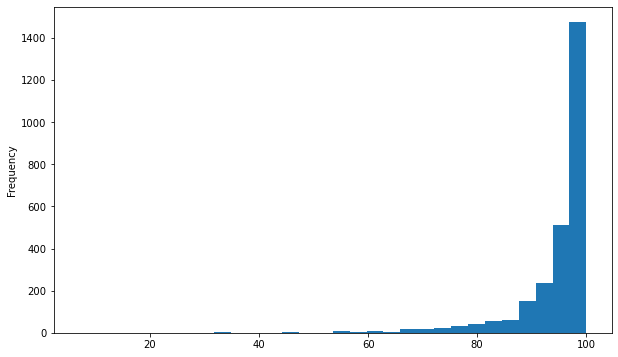

In [13]:
X_processed[X_processed['Rating'] > 0]['Rating'].plot.hist(bins = 30, figsize=(10,6))

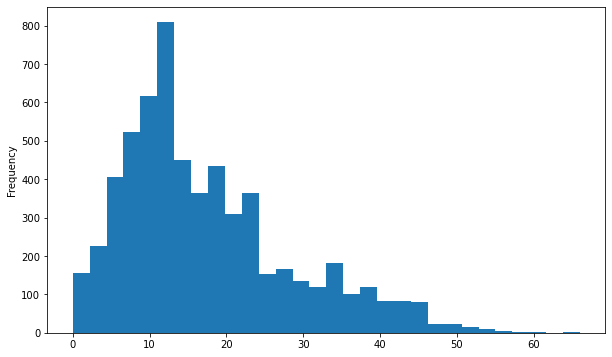

In [14]:
X_processed['Experience'].plot.hist(bins = 30, figsize=(10,6))

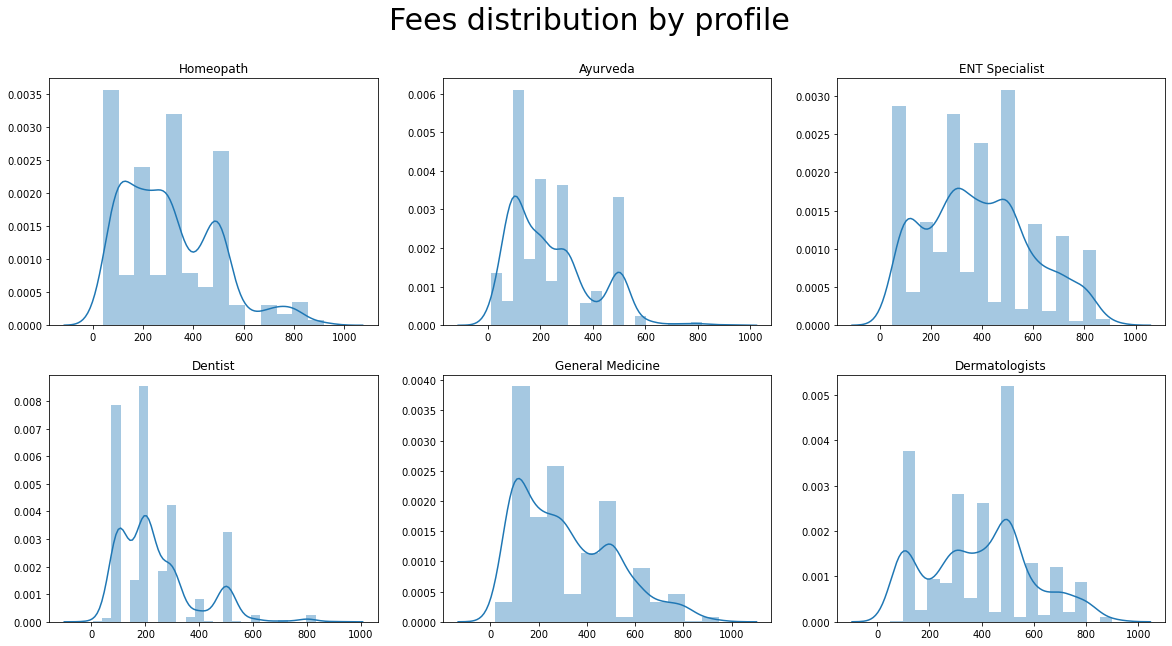

In [15]:
fig, ax = plt.subplots(2, 3, figsize = (20,10))
fig.suptitle('Fees distribution by profile', fontsize = 30)
r = 0
c = 0
for prof in X_processed['Profile'].unique():
    sns.distplot(Y[X_processed['Profile'] == prof], ax = ax[r][c])
    ax[r][c].set_title(profile_encoder.inverse_transform([prof])[0])
    ax[r][c].set(xlabel=None)
    c += 1
    if c == 3:
        c = 0
        r += 1

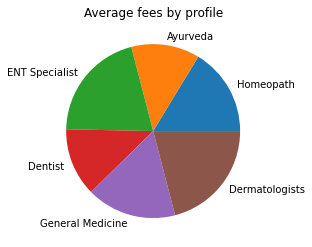

In [16]:
plt.title('Average fees by profile')
plt.pie(
    [Y[X_processed['Profile'] == prof].mean() for prof in X_processed['Profile'].unique()],
    labels = profile_encoder.inverse_transform(X_processed['Profile'].unique())
)
plt.show()

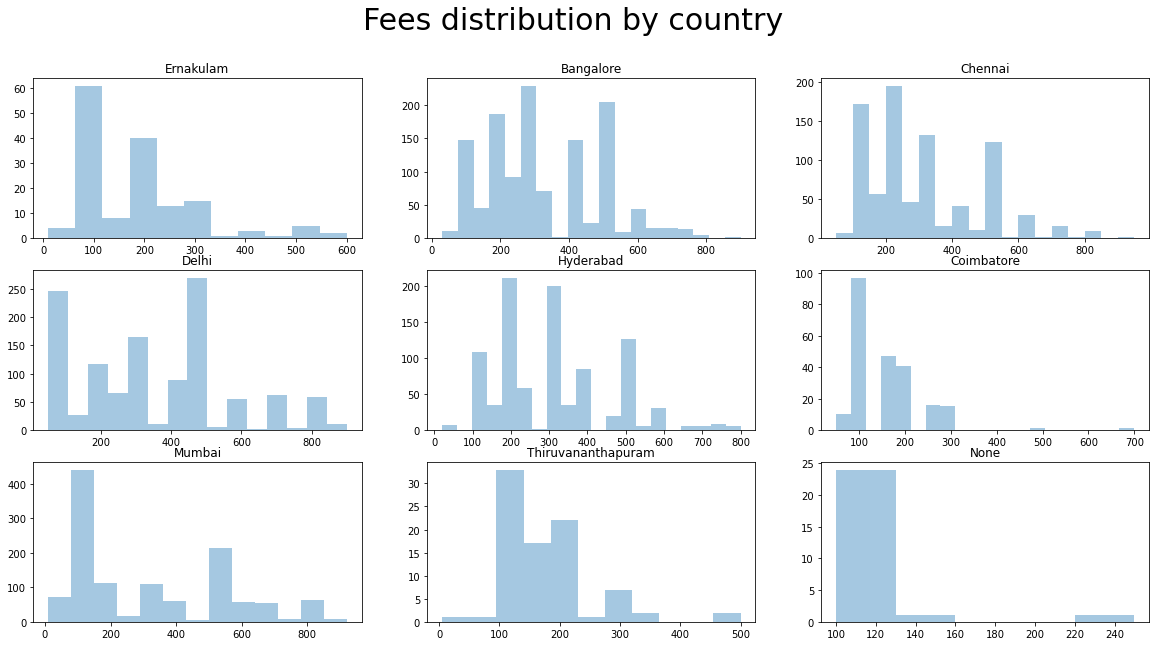

In [17]:
fig, ax = plt.subplots(3, 3, figsize = (20,10))
fig.suptitle('Fees distribution by country', fontsize = 30)
r = 0
c = 0
for country in X_processed['Country'].unique():
    if country == 8:
        continue
    sns.distplot(Y[X_processed['Country'] == country], ax = ax[r][c], kde = False)
    ax[r][c].set_title(country_encoder.inverse_transform([country])[0])
    ax[r][c].set(xlabel=None)
    c += 1
    if c == 3:
        c = 0
        r += 1

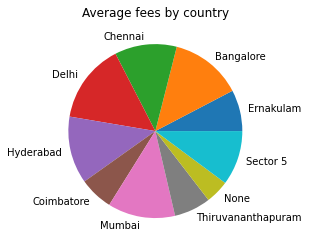

In [18]:
plt.title('Average fees by country')
plt.pie(
    [Y[X_processed['Country'] == Country].mean() for Country in X_processed['Country'].unique()],
    labels = country_encoder.inverse_transform(X_processed['Country'].unique())
)
plt.show()

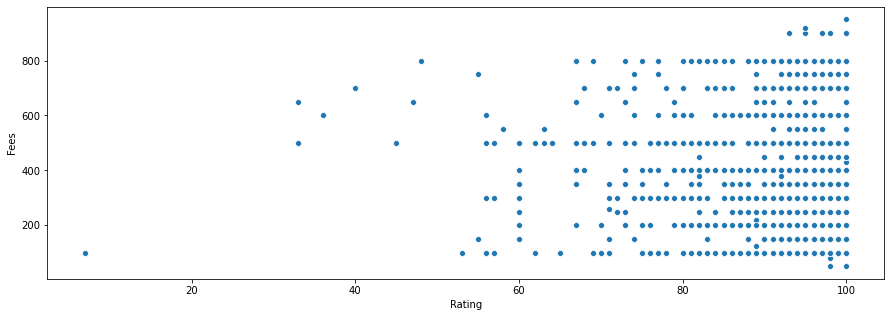

In [19]:
plt.figure(figsize=(15,5))
sns.scatterplot(X_processed[X_processed['Rating'] >= 0]['Rating'], Y[X_processed['Rating'] >= 0])

<h1>Model</h1>

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
rfr = RandomForestRegressor(criterion='mse')
rfr.fit(X_processed, Y)

RandomForestRegressor()

In [22]:
print("mse = " + str(np.sqrt(mean_squared_error(Y, rfr.predict(X_processed)))))

mse = 65.0643712988541


In [23]:
print("score = " + str(rfr.score(X_processed, Y)))

score = 0.8838404854387081
